<a href="https://colab.research.google.com/github/bahargermany134-dotcom/rsnaPneumoniaDetection/blob/main/rsnaPneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
zip_path = '/content/drive/MyDrive/ rsna-pneumonia-detection-challenge.zip'
print(os.path.exists(zip_path))

True


In [3]:
import zipfile
extract_path = '/content/rsna-data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("فایل‌ها استخراج شدند:")
print(os.listdir(extract_path))


فایل‌ها استخراج شدند:
['__MACOSX', 'rsna-pneumonia-detection-challenge']


In [4]:
data_path='/content/rsna-data/rsna-pneumonia-detection-challenge'
print(os.listdir(data_path))

['stage_2_detailed_class_info.csv', 'stage_2_test_images', 'stage_2_train_labels.csv', 'stage_2_train_images', 'GCP Credits Request Link - RSNA.txt', 'stage_2_sample_submission.csv']


In [5]:
import pandas as pd
train_labels=pd.read_csv('/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
train_labels.head()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
print(train_labels['Target'].value_counts())

Target
0    20672
1     9555
Name: count, dtype: int64


In [7]:
!pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.7 MB/s eta 0:00:00


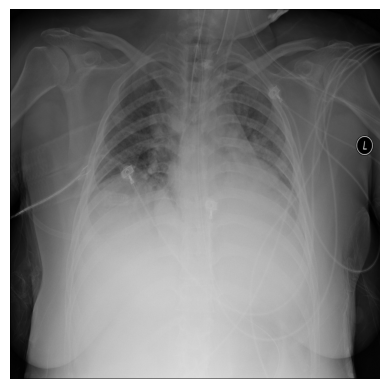

In [8]:
import pydicom
import matplotlib.pyplot as plt
dicom_path = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
dicom = pydicom.dcmread(dicom_path)
image = dicom.pixel_array
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


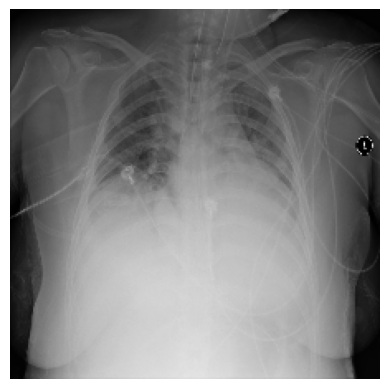

In [9]:
import numpy as np
import cv2
def preprocess_dicom(dicom_path, target_size=(224, 224)):
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array
    #normalization to [255,0]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    #resize
    image=cv2.resize(image,target_size)
    return image
#preprocessing test
preprocessed_image=preprocess_dicom(dicom_path)
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pydicom
import cv2
import numpy as np

# تابع پیش‌پردازش با بازگشت اندازه اصلی
def preprocess_dicom(dicom_path, size=(224, 224)):
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array
    original_size = image.shape  # اندازه اصلی (height, width)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image = cv2.resize(image, size)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image, original_size
    #return image

# کلاس دیتاست با مقیاس‌بندی باکس‌ها
class PneumoniaDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None, target_size=(224, 224)):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.patient_ids = labels['patientId'].unique()

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        dicom_path = os.path.join(self.root_dir, f'{patient_id}.dcm')
        image, original_size = preprocess_dicom(dicom_path, size=self.target_size)
        if self.transform:
            image = self.transform(image)

        # استخراج لیبل و باکس‌ها
        target = {}
        patient_data = self.labels[self.labels['patientId'] == patient_id]
        if patient_data['Target'].iloc[0] == 1:
            boxes_data = patient_data[['x', 'y', 'width', 'height']].dropna().values
            boxes = []
            # مقیاس‌بندی باکس‌ها
            orig_height, orig_width = original_size
            new_height, new_width = self.target_size
            for box in boxes_data:
                x, y, w, h = box
                # مقیاس‌بندی مختصات
                x = x * new_width / orig_width
                y = y * new_height / orig_height
                w = w * new_width / orig_width
                h = h * new_height / orig_height
                boxes.append([x, y, x + w, y + h])  # [x_min, y_min, x_max, y_max]
            target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
            target['labels'] = torch.ones(len(boxes), dtype=torch.int64)
        else:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros(0, dtype=torch.int64)

        return image, target

# مسیر داده‌ها و ایجاد دیتاست
image_dir = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_labels = pd.read_csv('/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
dataset = PneumoniaDataset(train_labels, image_dir, transform=transforms.ToTensor())

اندازه تصویر: torch.Size([3, 224, 224])
باکس‌ها: tensor([[ 57.7500,  33.2500, 104.3438, 116.1562],
        [122.9375,  33.2500, 178.9375, 132.3438]])
لیبل‌ها: tensor([1, 1])


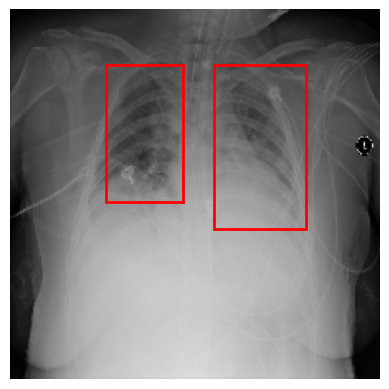

In [11]:
# تست ۱ نمونه
image, target = dataset[4]
print("اندازه تصویر:", image.shape)
print("باکس‌ها:", target['boxes'])
print("لیبل‌ها:", target['labels'])

# نمایش تصویر و باکس‌ها
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image_np = image.permute(1, 2, 0).numpy()  # تبدیل tensor به numpy
fig, ax = plt.subplots(1)
ax.imshow(image_np)
for box in target['boxes']:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [12]:
from torch.utils.data import DataLoader

# تابع collate_fn برای مدیریت batch
def collate_fn(batch):
    return tuple(zip(*batch))

# ایجاد دیتالودر
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [13]:
# گرفتن یک batch
images, targets = next(iter(dataloader))
print("تعداد تصاویر در batch:", len(images))
print("اندازه تصویر اول:", images[0].shape)
print("باکس‌های نمونه اول:", targets[0]['boxes'])
print("لیبل‌های نمونه اول:", targets[0]['labels'])

تعداد تصاویر در batch: 2
اندازه تصویر اول: torch.Size([3, 224, 224])
باکس‌های نمونه اول: tensor([], size=(0, 4))
لیبل‌های نمونه اول: tensor([], dtype=torch.int64)


In [14]:
small_labels = train_labels[train_labels['patientId'].isin(train_labels['patientId'].unique()[:3000])]
dataset = PneumoniaDataset(small_labels, image_dir, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [15]:
#Model
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model=fasterrcnn_resnet50_fpn(pretrained=True)
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 110MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [16]:
import torch.optim as optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, targets) in enumerate(dataloader):
        try:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
            if i % 10 == 0:  # هر ۱۰ دسته چاپ کن
                print(f"Epoch {epoch+1}, Batch {i}, Loss: {losses.item()}")
        except Exception as e:
            print(f"Error in Batch {i}: {str(e)}")
            continue
    print(f"Epoch {epoch+1}, Average Loss: {running_loss / len(dataloader)}")
    torch.save(model.state_dict(), f'/content/rsna-data/model_epoch_{epoch+1}.pth')

Epoch 1, Batch 0, Loss: 0.27467241883277893
Epoch 1, Batch 10, Loss: 0.6020307540893555
Epoch 1, Batch 20, Loss: 0.005695123225450516
Epoch 1, Batch 30, Loss: 0.18288537859916687
Epoch 1, Batch 40, Loss: 0.01629067026078701
Epoch 1, Batch 50, Loss: 0.016434509307146072
Epoch 1, Batch 60, Loss: 0.4009115397930145
Epoch 1, Batch 70, Loss: 0.019744016230106354
Epoch 1, Batch 80, Loss: 0.32786834239959717
Epoch 1, Batch 90, Loss: 0.2740005552768707
Epoch 1, Batch 100, Loss: 0.029690440744161606
Epoch 1, Batch 110, Loss: 0.206007182598114
Epoch 1, Batch 120, Loss: 0.7973819971084595
Epoch 1, Batch 130, Loss: 0.3460152745246887
Epoch 1, Batch 140, Loss: 0.004481131676584482
Epoch 1, Batch 150, Loss: 0.04701566323637962
Epoch 1, Batch 160, Loss: 0.02977610006928444
Epoch 1, Batch 170, Loss: 0.37223678827285767
Epoch 1, Batch 180, Loss: 0.023456141352653503
Epoch 1, Batch 190, Loss: 0.1681589037179947
Epoch 1, Batch 200, Loss: 0.024618547409772873
Epoch 1, Batch 210, Loss: 0.5123975872993469
E

In [17]:
class PneumoniaTestDataset(Dataset):
    def __init__(self, root_dir, patient_ids, transform=None):
        self.root_dir = root_dir
        self.patient_ids = list(patient_ids)  # اطمینان از لیست بودن
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        dicom_path = os.path.join(self.root_dir, f'{patient_id}.dcm')
        image, _ = preprocess_dicom(dicom_path)  # فقط تصویر رو بگیر، original_size رو نادیده بگیر
        if self.transform:
            image = self.transform(image)
        return image, patient_id

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

# لود patient IDهای تست
sample_submission = pd.read_csv('/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv')
test_patient_ids = sample_submission['patientId'].unique().tolist()
print("تعداد patient IDs:", len(test_patient_ids))
print("چند نمونه patient ID:", test_patient_ids[:5])

# مسیر داده‌های تست
test_image_dir = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_test_images'
print("چند نمونه فایل تست:", os.listdir(test_image_dir)[:5])

# ایجاد دیتاست و دیتالودر
test_dataset = PneumoniaTestDataset(test_image_dir, test_patient_ids, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

تعداد patient IDs: 3000
چند نمونه patient ID: ['0000a175-0e68-4ca4-b1af-167204a7e0bc', '0005d3cc-3c3f-40b9-93c3-46231c3eb813', '000686d7-f4fc-448d-97a0-44fa9c5d3aa6', '000e3a7d-c0ca-4349-bb26-5af2d8993c3d', '00100a24-854d-423d-a092-edcf6179e061']
چند نمونه فایل تست: ['0068492c-2cc4-46b3-9ac5-ccb80fc10c96.dcm', '1f670057-5030-4549-8a10-392fb97f520f.dcm', '30ed769a-8105-47a0-8d1a-4692f5df5fad.dcm', '255f3ba9-89bc-4ce4-840d-43267635124e.dcm', '04026d9e-895d-4b87-9d73-3d6fb58e53a3.dcm']


In [19]:
try:
    images, patient_ids = next(iter(test_dataloader))
    print("اندازه تصویر:", images[0].shape)  # باید [3, 224, 224]
    print("Patient ID:", patient_ids[0])
except Exception as e:
    print(f"خطا در دیتالودر: {str(e)}")

اندازه تصویر: torch.Size([3, 224, 224])
Patient ID: 0000a175-0e68-4ca4-b1af-167204a7e0bc


In [20]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# بارگذاری مدل
model = fasterrcnn_resnet50_fpn(pretrained=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/content/drive/MyDrive/RSNA_Data/model_epoch_1.pth'))
model.to(device)
model.eval()

# تولید پیش‌بینی‌ها
predictions = []
with torch.no_grad():
    for images, patient_ids in test_dataloader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for patient_id, output in zip(patient_ids, outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            # فقط باکس‌های با امتیاز بالا
            valid_boxes = boxes[scores > 0.5]
            valid_scores = scores[scores > 0.5]

            # تبدیل به فرمت Kaggle
            prediction_strings = []
            for box, score in zip(valid_boxes, valid_scores):
                x_min, y_min, x_max, y_max = box
                x_min = x_min * 1024 / 224
                y_min = y_min * 1024 / 224
                width = (x_max - x_min) * 1024 / 224
                height = (y_max - y_min) * 1024 / 224
                prediction_strings.append(f"{score:.3f} {x_min:.1f} {y_min:.1f} {width:.1f} {height:.1f}")

            prediction_string = " ".join(prediction_strings) if prediction_strings else ""
            predictions.append([patient_id, prediction_string])

# ذخیره submission
submission_df = pd.DataFrame(predictions, columns=['patientId', 'PredictionString'])
submission_df.to_csv('/content/drive/MyDrive/RSNA_Data/submission.csv', index=False)
print("فایل submission.csv ذخیره شد")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


فایل submission.csv ذخیره شد


In [21]:
import pandas as pd
from torch.utils.data import DataLoader

# لود داده‌های آموزشی
labels_path = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
image_dir = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_labels = pd.read_csv(labels_path)

# محدود کردن به 500 نمونه برای سرعت
train_labels_small = train_labels[train_labels['patientId'].isin(train_labels['patientId'].unique()[:500])]

# تعریف دیتاست و دیتالودر
train_dataset = PneumoniaDataset(train_labels_small, image_dir, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

print("تعداد نمونه‌های آموزشی:", len(train_dataset))
print("چند نمونه patient ID:", train_dataset.patient_ids[:5])

تعداد نمونه‌های آموزشی: 500
چند نمونه patient ID: ['0004cfab-14fd-4e49-80ba-63a80b6bddd6'
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd'
 '00322d4d-1c29-4943-afc9-b6754be640eb'
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
 '00436515-870c-4b36-a041-de91049b9ab4']


In [23]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
import pydicom
import numpy as np

# تابع پیش‌پردازش DICOM
def preprocess_dicom(dicom_path, size=(224, 224)):
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array
    original_size = image.shape
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image = cv2.resize(image, size)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image, original_size

# کلاس دیتاست
class PneumoniaDataset(Dataset):
    def __init__(self, labels, image_dir, transform=None, target_size=(224, 224)):
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size
        self.patient_ids = labels['patientId'].unique()

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        dicom_path = os.path.join(self.image_dir, f'{patient_id}.dcm')
        image, original_size = preprocess_dicom(dicom_path, self.target_size)
        if self.transform:
            image = self.transform(image)
        target = {}
        patient_data = self.labels[self.labels['patientId'] == patient_id]
        if patient_data['Target'].iloc[0] == 1:
            boxes_data = patient_data[['x', 'y', 'width', 'height']].dropna().values
            boxes = []
            orig_height, orig_width = original_size
            new_height, new_width = self.target_size
            for box in boxes_data:
                x, y, w, h = box
                x = x * new_width / orig_width
                y = y * new_height / orig_height
                w = w * new_width / orig_width
                h = h * new_height / orig_height
                boxes.append([x, y, x + w, y + h])
            target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
            target['labels'] = torch.ones(len(boxes), dtype=torch.int64)
        else:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros(0, dtype=torch.int64)
        return image, target, patient_id  # خروجی سه‌تایی

# لود داده‌های آموزشی
labels_path = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
image_dir = '/content/rsna-data/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_labels = pd.read_csv(labels_path)

# محدود کردن به 500 نمونه برای سرعت
train_labels_small = train_labels[train_labels['patientId'].isin(train_labels['patientId'].unique()[:500])]

# تعریف دیتاست و دیتالودر
train_dataset = PneumoniaDataset(train_labels_small, image_dir, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

# تست دیتالودر برای اطمینان از خروجی سه‌تایی
images, targets, patient_ids = next(iter(train_dataloader))
print("اندازه تصاویر:", images[0].shape)
print("تعداد تارگت‌ها:", len(targets))
print("چند نمونه patient ID:", patient_ids[:5])
print("تعداد نمونه‌های آموزشی:", len(train_dataset))

اندازه تصاویر: torch.Size([3, 224, 224])
تعداد تارگت‌ها: 4
چند نمونه patient ID: ('0004cfab-14fd-4e49-80ba-63a80b6bddd6', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd', '00322d4d-1c29-4943-afc9-b6754be640eb', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5')
تعداد نمونه‌های آموزشی: 500


In [24]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for images, targets, patient_ids in dataloader:  # خروجی سه‌تایی
            images = list(image.to(device) for image in images)
            outputs = model(images)
            preds = [{'boxes': out['boxes'].cpu(), 'scores': out['scores'].cpu(), 'labels': out['labels'].cpu()} for out in outputs]
            targets = [{'boxes': t['boxes'].cpu(), 'labels': t['labels'].cpu()} for t in targets]
            metric.update(preds, targets)
    mAP = metric.compute()
    return mAP

# ارزیابی روی دیتاست آموزشی
mAP = evaluate_model(model, train_dataloader, device)
print("نتایج mAP:", mAP)

نتایج mAP: {'map': tensor(0.1159), 'map_50': tensor(0.3860), 'map_75': tensor(0.0283), 'map_small': tensor(0.0083), 'map_medium': tensor(0.1285), 'map_large': tensor(0.1842), 'mar_1': tensor(0.1344), 'mar_10': tensor(0.3228), 'mar_100': tensor(0.3446), 'mar_small': tensor(0.0714), 'mar_medium': tensor(0.3822), 'mar_large': tensor(0.2905), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


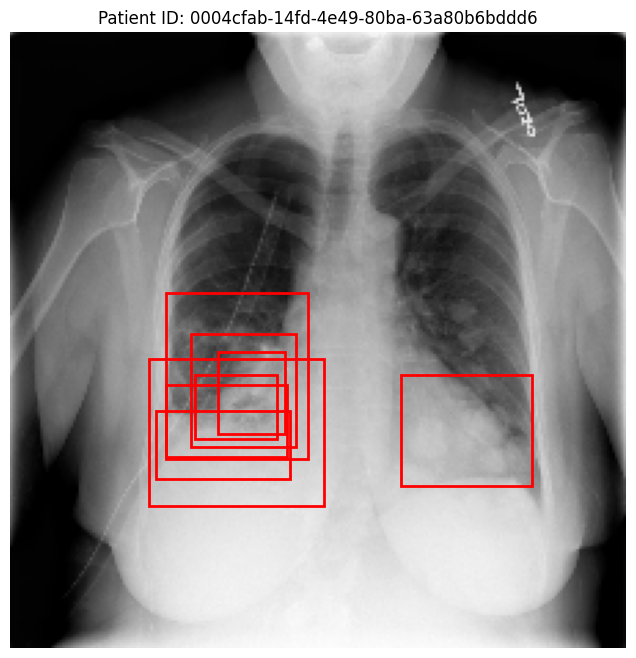

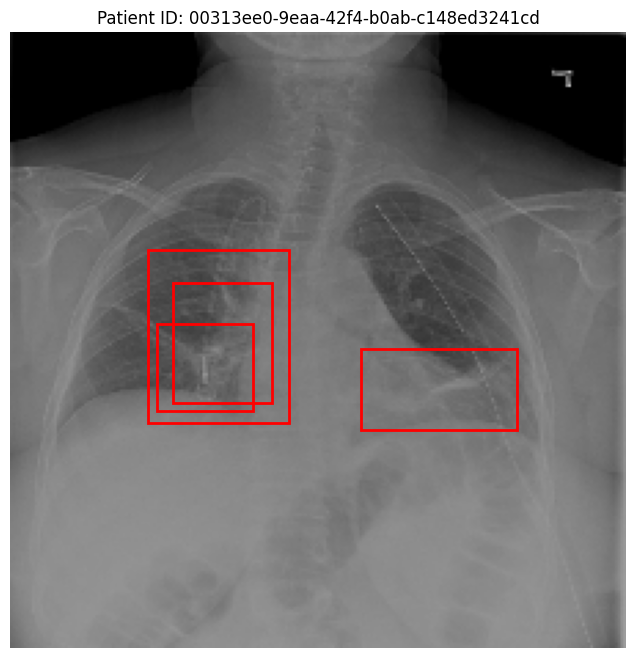

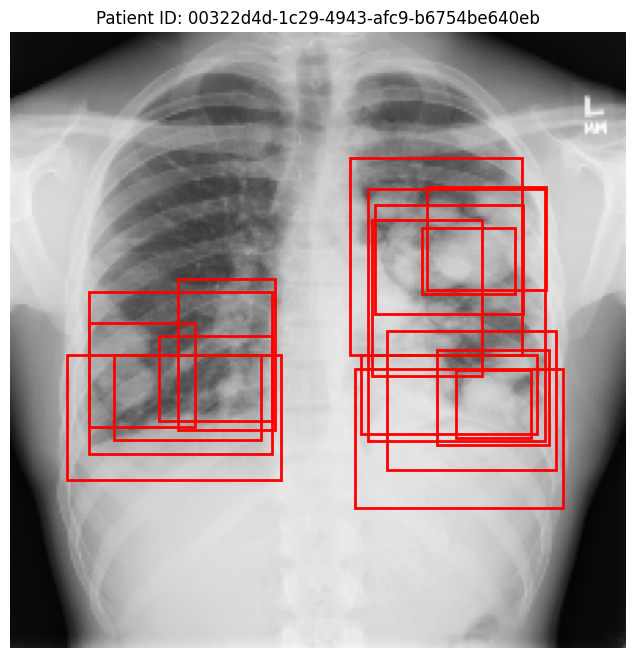

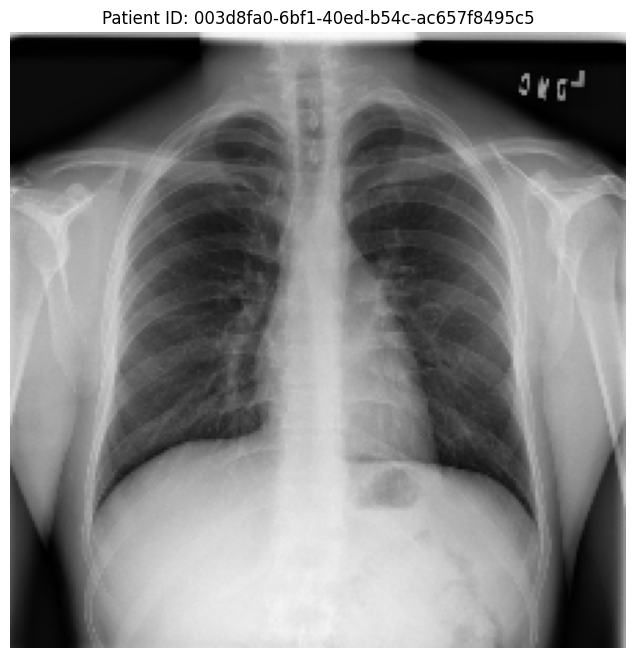

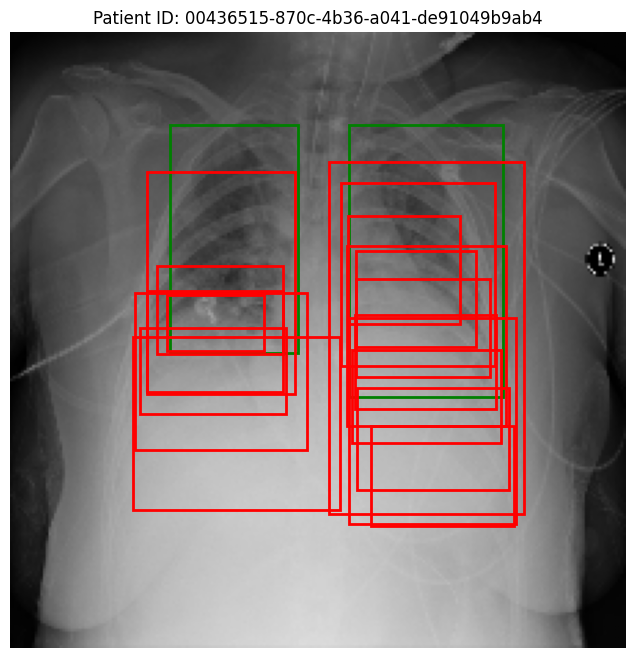

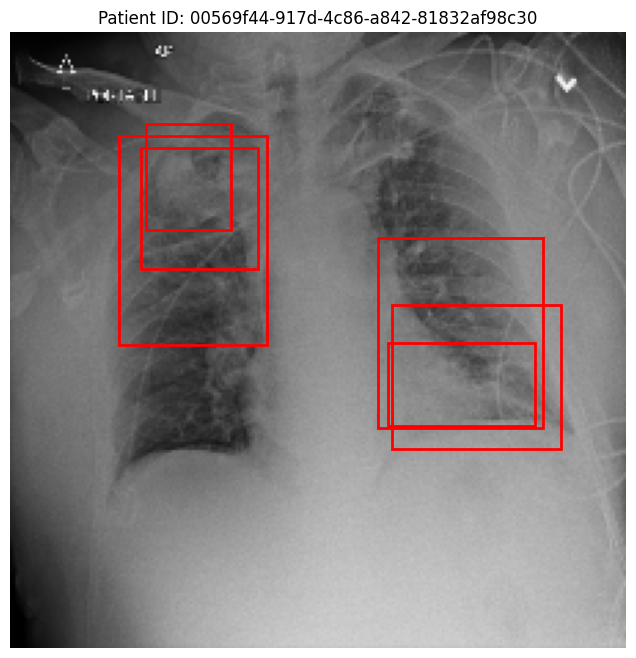

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(image, gt_boxes, pred_boxes, patient_id):
    image = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f'Patient ID: {patient_id}')

    # باکس‌های واقعی (GT) - سبز
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # باکس‌های پیش‌بینی‌شده - قرمز
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# ویژوالایزیشن روی ۳ نمونه
model.eval()
with torch.no_grad():
    for i in range(6):
        image, target, patient_id = train_dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)[0]
        visualize_sample(image[0], target['boxes'].cpu().numpy(), output['boxes'].cpu().numpy(), patient_id)

In [26]:
import pandas as pd

submission_df = pd.read_csv('/content/drive/MyDrive/RSNA_Data/submission.csv')
print("چند نمونه از submission:")
print(submission_df.head())
print("تعداد ردیف‌ها:", len(submission_df))

چند نمونه از submission:
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc              NaN
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813              NaN
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6              NaN
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d              NaN
4  00100a24-854d-423d-a092-edcf6179e061              NaN
تعداد ردیف‌ها: 3000
